### Forecasting
In this task, we explore the forecasting models from statsmodel, for example, AR, MA, ARMA/ARIMA, SARIMA. The main motivation behind doing this task is to understand how to  model the timeseries data with these algorithms. 

To do this task, I have used the dataset- 'airline passenger' to all agorithms. And, figure out which algorithm is suitable for this data type. In addition, this notebook gives how to apply the stationarity check with augmented Dickey-Fuller Test. 

In [1047]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams #set figure size

from pmdarima import auto_arima # for finding arima orders

# for metric
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

from statsmodels.tsa.stattools import adfuller # for stationarity test
from statsmodels.tsa.statespace.tools import diff 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot,quarter_plot #plots

#for creating models
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [712]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [726]:
#load dataset
df= pd.read_csv('Data/airline_passengers.csv', index_col='Month', parse_dates=True)
df.index.freq = 'MS'# since data is monthly start frequency
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


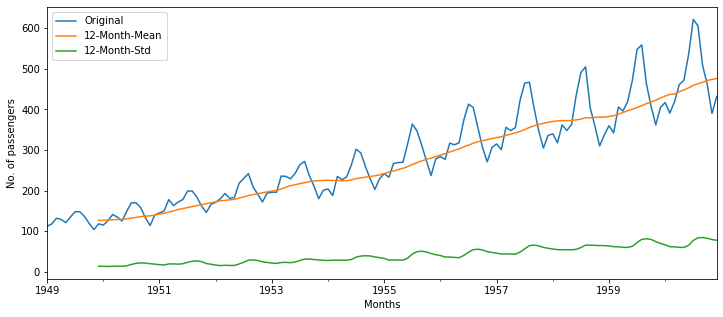

In [1189]:
#lets visualize the data
ax = df['Thousands of Passengers'].plot(figsize=(12,5), legend= True, label='Original')
df['Thousands of Passengers'].rolling(window=12).mean().plot(legend= True, label='12-Month-Mean')
df['Thousands of Passengers'].rolling(window=12).std().plot(legend= True, label='12-Month-Std')

ax.autoscale(axis='x',tight=True) # fit to x-axis
ylabel='No. of passengers'
xlabel = 'Months'
ax.set(xlabel=xlabel, ylabel=ylabel) #name axis
plt.show()

From the plot, it clearly shows  that this is non-stationary series since the  mean and standard deviation keep on variation with resect to time period. Even, we can see that this series has clear upward trend. We will perfome statistical test to test stationary or not  later in this work.

### ETS Decompostion
Lets look the general behaviour in series. From ETS decomposition, we may get idea/clue whether time series has trend, seasonlaity or not. 

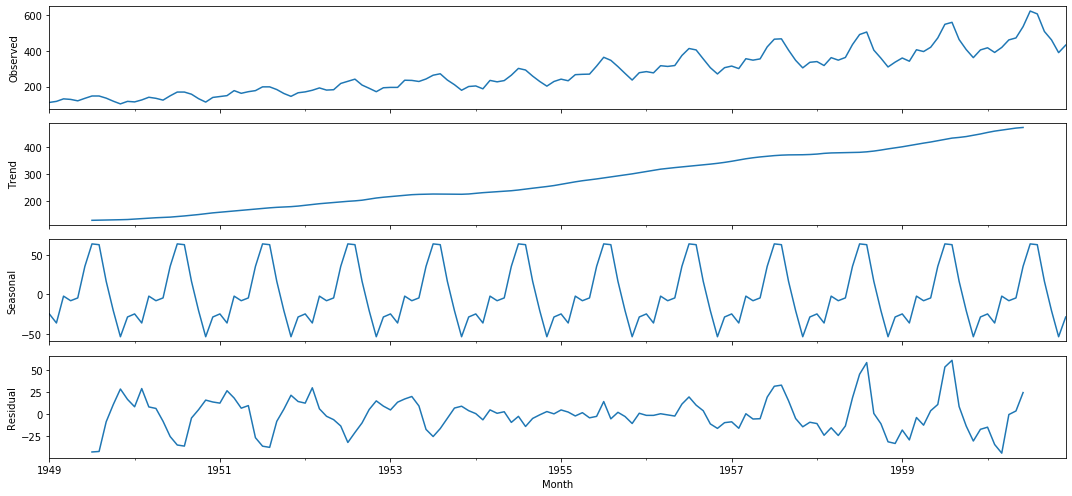

In [715]:
# lets do seasonal decompostion
rcParams['figure.figsize']=15,7 # set figure size
sea_decom = seasonal_decompose(df['Thousands of Passengers'], model='additive')
sea_decom.plot();

Figures show clear upward trend and may be some seasonlity

### Auto/Partial Correlation Plot
These plots are usually used for finding the 'p' and 'q' for ARIMA model, but in this notebook instead of using this classical method we will use auto_arima() function. To check whether or not there is correlation with the shiffted samples in the time series, these plots are also useful. 

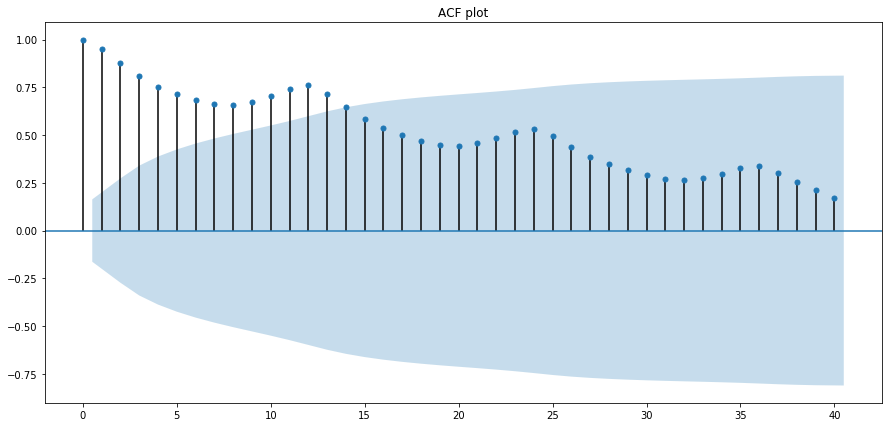

In [728]:
#create auto correaltion plot
plot_acf(df['Thousands of Passengers'], lags=40, title='ACF plot')
plt.show()

Figure shows  there is  correlation as well as seasonality in certian periods.

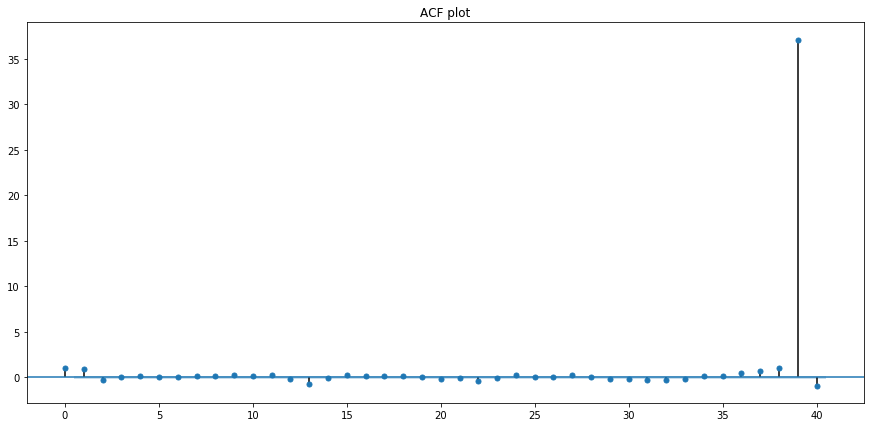

In [1204]:
#create partial correaltion plot
plot_pacf(df['Thousands of Passengers'], lags=40, title='ACF plot');

###  Seasonality and quaterly plot 
Lets figure out, which months and qauterly have low and high passenger.

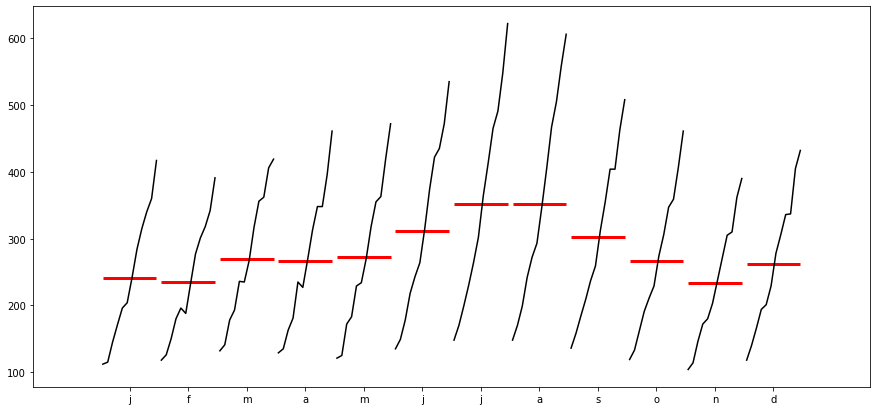

In [1011]:
#monthly plot
month_plot(df['Thousands of Passengers']);


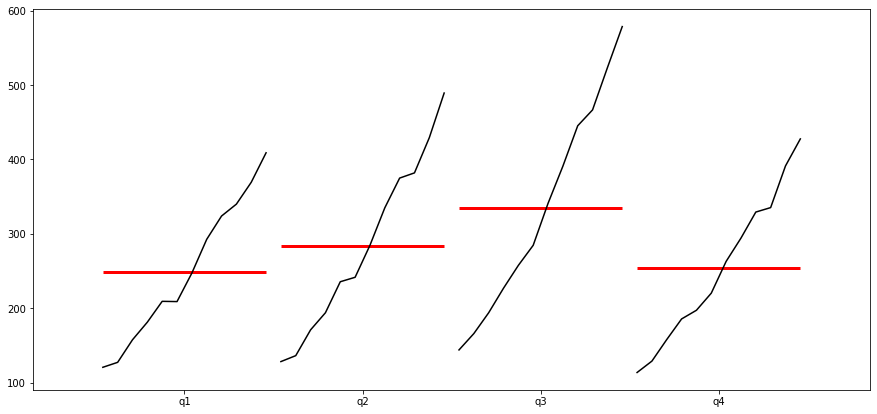

In [1012]:
#quaterly plot
quarter_plot(df['Thousands of Passengers'].resample(rule='Q').mean());

From both quaterly and montly plots, we can see there is some up and down in the airplane passenger.
For the month of JUNE and JULY there is high peak as same as in  3rd quater.

### Stationarized Time Series
We have to stationarize the time series data. From the above figures, it is clear seen that there is seasonlity and trend in series. But lets do statistic to proof that the series is stationary or  non-stationary(shows seasonality or trend).

For this, the augmented Dickey-Fuller Test is used. It tests the hypothesises. Here, the null hyothesis is 'non-stationary'. We will use the significance level of 0.05 percentage.


In [1196]:
def adfuller_test(time_series):
    """
     time_series= time series data
     returns an ADF report
     
    """
    
    # create adfuller  report
    result = adfuller(time_series, autolag='AIC') 
    
    
    #assigin the each value with name and store as pands series
    labels = ['ADF_test','p-value','lags used','observations']
    out = pd.Series(result[0:4],index=labels) #create series

    for key,val in result[4].items(): # add items(critical values) 
        out[f'critical value ({key})']=val
        
   
    #print out
    print(out)
    
   #check hypothesis 
    if np.round(result[1], 2) <= 0.05:
        print("Strong evidence against  to reject  null hypothesis")
        print("It is stationary")
    else:
        print("Weak evidence against  to reject null hypothesis")
        print("It is non-stationary")

In [1197]:
#check stationary 
adfuller_test(df['Thousands of Passengers'])

ADF_test                  0.815369
p-value                   0.991880
lags used                13.000000
observations            130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
dtype: float64
Weak evidence against  to reject null hypothesis
It is non-stationary


It tells that this time series data is non-stationary. So, we have  to make it stationary. I have used differencing
technique to make it stationary.

### Models
Lets build the models from  different alogrithms, like AR,MA, ARMA/ARIMA, SARIMA.

Note: we know clearly that this dataset is non-stationary(shows trend or seasonality), which is not suitable to model with AR, MA, ARMA since they are not able to learn trend and seasonl in dataset. But also lets try how it do in prediction.

In [1198]:

'''
Note: this is just to understand for myself at what differencing the series become stationary
'''

# return stationary data with 95% confidence level(0.05 significance level)
def return_stationary_series(series, k=2):
    '''
    series = time series data
    k = differecing time 
    return  stationary time seres data
    '''
    for d in range(1, k):
        df_stat = diff(df['Thousands of Passengers'], k_diff = d) # differencing data

        # check p-value
        if np.round(adfuller(df_stat)[1]) <= 0.05:  # round with 2 decimal values
            print(f'Now the time-series is stationary at {d} difference')
            return df_stat
            break
        



Now the time-series is stationary at 1 difference


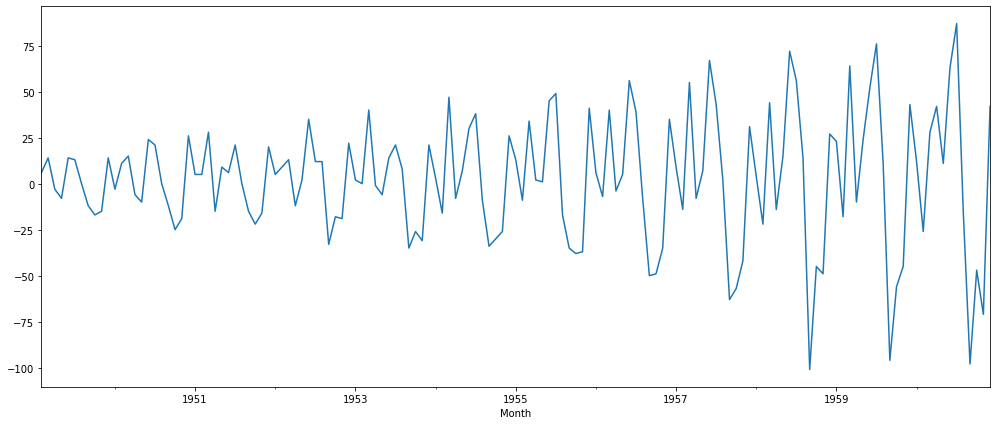

In [1205]:
#return stationary series and plot
stationary_series =return_stationary_series(df['Thousands of Passengers'], 10)
stationary_series.plot(figsize=(17,7));

Now, the series looks as stationary. We can test with calling the function adfuller_test().

In [1206]:
# testing for stationary
adfuller_test(stationary_series)

ADF_test                 -2.829267
p-value                   0.054213
lags used                12.000000
observations            130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
dtype: float64
Strong evidence against  to reject  null hypothesis
It is stationary


###  Train_Test split

In [1207]:
#convert to dataframe
stat_data = stationary_series.to_frame() 

#split test(36 months) and train(remaining months)
train_data_stationary = stat_data.iloc[:-36] 
test_data_stationary = stat_data.iloc[-36:] 

#original data(non-stationary)
train_data= df.iloc[:-36]
test_data= df.iloc[-36:] 
 

### Autoregression(AR) Model
In this autoregression model, the linear combination of past values of the series are happened. It is calculated against a set of lagged values of order  𝑝 . We are using auto_arima() function to find the best 'p' for AR in this dataset.

In [1208]:
#suggest  model
auto_arima(stat_data, seasonal=False).summary() # use stationary data

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:                     ARMA(2, 4)   Log Likelihood                -661.292
Method:                       css-mle   S.D. of innovations             23.715
Date:                Mon, 18 Nov 2019   AIC                           1338.585
Time:                        20:17:09   BIC                           1362.288
Sample:                             0   HQIC                          1348.216
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6854      0.134     19.979      0.000       2.422       2.949
ar.L1.y        0.9142      0.082     11.131      0.000       0.753       1.075
ar.L2.y       -0.7709      0.080     -9.629      0.000      -0.928      -0.614
ma.L1.y       -0.8356      0.101     -8.265      0.000      -1.034      -0.637
ma.L2.y        0.3271      0.122      2.691      0.008       0.089       0.565
ma.L3.y        0.3086      0.114      2.699      0.008       0.085       0.533
ma.L4.y       -0.8000      0.079    -10.112      0.000      -0.955      -0.645
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5929           -0.9724j            1.1389           -0.1628
AR.2            0.5929           +0.9724j            1.1389            0.1628
MA.1            1.0001           -0.0000j            1.0001           -0.0000
MA.2            0.3178           -0.9481j            1.0000           -0.1985
MA.3            0.3178           +0.9481j            1.0000            0.1985
MA.4           -1.2500           -0.0000j            1.2500           -0.5000
-----------------------------------------------------------------------------
"""

#### Build AR model

In [1238]:
# AR model
model_ar = AR(train_data_stationary['Thousands of Passengers']) # use stationary data
#best_lag = model_ar.select_order(maxlag= 20,trend='nc', ic='aic') # select best maxlag
#print(f'best lag: {best_lag}')

# fit model with suggested p
model_ar_fit = model_ar.fit(maxlag= 2) 

#predict test data
ar_prediction = model_ar_fit.predict(start= test_data_stationary.index[0], 
                                     end= test_data_stationary.index[-1], 
                                     dynamic=False)
ar_prediction.head()

1958-01-01    23.500473
1958-02-01     2.308398
1958-03-01    -3.271831
1958-04-01     0.140311
1958-05-01     2.762978
Freq: MS, dtype: float64

### Invert Transformation
Since our prediction values are already scaled with 1 differencing, we have to change it back to orginal scale before ploting and forecasting. You can obtained this result either by 1) summing columns (original value + stationary values/predictived values) or  2) just recent values of train data + prediction values using cumsum() function 

In [1239]:
#create dataframe
test_data_stationary['Passengers(original)'] = test_data['Thousands of Passengers'] # original scale 

# store predicted value in dataframe
test_data_stationary['Prediction_1d_AR'] = ar_prediction 

# add most recent  value from training dataset and do cumsum in stationary values
test_data_stationary['Inverted_1d_AR'] = df['Thousands of Passengers'].iloc[-len(test_data_stationary)-1] + test_data_stationary['Prediction_1d_AR'].cumsum()

#test_data_stationary['Inverted_Values'] = df['Thousands of Passengers'].iloc[-len(test_data_stationary)-1:-1].values + test_data_stationary['Prediction_1d_scale'].values
test_data_stationary.head()



,Thousands of Passengers,Passengers(original),Prediction_1d_AR,Inverted_1d_AR
Month,,,,
1958-01-01,4.0,340,23.500473,359.500473
1958-02-01,-22.0,318,2.308398,361.808871
1958-03-01,44.0,362,-3.271831,358.537040
1958-04-01,-14.0,348,0.140311,358.677351
1958-05-01,15.0,363,2.762978,361.440329


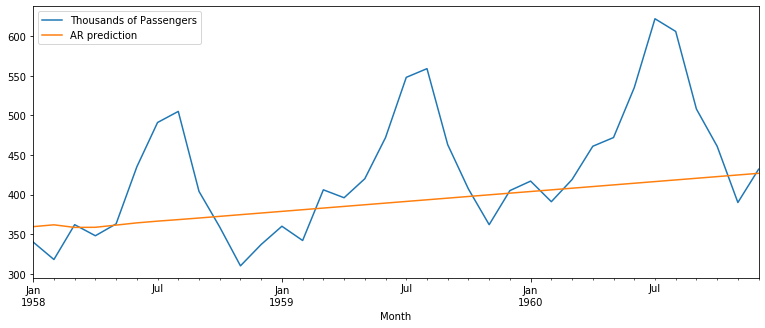

In [1240]:
# create plot with test and predicted
test_data.plot(legend= True, label= 'test data')
test_data_stationary['Inverted_1d_AR'].plot(legend= True, label='AR prediction', figsize=(13,5))
plt.show()

Pretty bad, right? We already know that this data has some seasonality. So AR model cann't address that problem. 
From the above figure also we can see that  this model is doing very  poor in capturing the peak and down parts. 

### Evaluate the Model

In [1241]:
# r2_score
r2_result = r2_score(test_data['Thousands of Passengers'], test_data_stationary['Inverted_1d_AR'])
r2_result

-0.026951254751961695

In [1242]:
# mean  absolute error
mean_absolute_error(test_data['Thousands of Passengers'], test_data_stationary['Inverted_1d_AR'])

56.63657955498565

#### Note: 
When we look at r2_score values, it is in negative which means poor prediciton.  So, we can say that  AR is too simple model for this dataset and it doesn't address the trend and  seasonality in the series.
    

### Forecasting

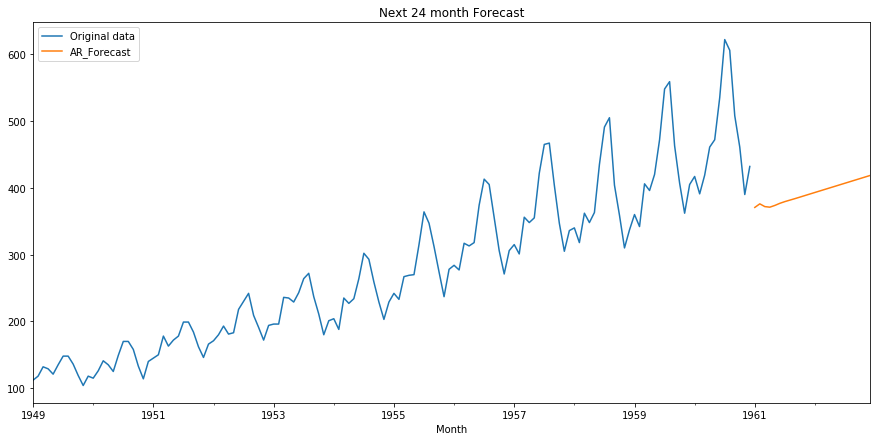

In [1245]:
# train with whole dataset(stationary)
ar_final_model = AR(stat_data['Thousands of Passengers']).fit(maxlag= 2, ic='aic')


#forecast next 24
ar_forecast = ar_final_model.predict(start= stat_data.index[-1]+1, 
                                      end=stat_data.index[-1]+24, 
                                      dynamic=False)

#invert to original scale
original_scale = df['Thousands of Passengers'].iloc[-len(test_data_stationary)-1] + ar_forecast.cumsum()



#create plots
ax=  df['Thousands of Passengers'].plot(legend= True, label='Original data', title='Next 24 month Forecast')
original_scale.plot(legend= True, label='AR_Forecast')

ax.legend(loc=2);

Very bad forecasting, right?

### Moving Average(MA) model
MA model is  a linear regression of the current value of the series against current and previous (observed) white noise error.

In [1248]:
#fit model 
ma_model = ARMA(train_data_stationary['Thousands of Passengers'], order=(0,4)).fit()

#predict test data
ma_prediction = ma_model.predict(start= test_data_stationary.index[0], 
                                     end= test_data_stationary.index[-1],
                                     dynamic=False)

# put into dataframe
test_data_stationary['Prediction_1D_MA'] = ma_prediction

#invert data to original scale ( since predicted result is 1 differencing)
test_data_stationary['Inverted_1d_MA'] = df['Thousands of Passengers'].iloc[-len(test_data_stationary)-1] + test_data_stationary['Prediction_1D_MA'].cumsum()
test_data_stationary.head()

,Thousands of Passengers,Passengers(original),Prediction_1d_AR,Inverted_1d_AR,Prediction_1D_MA,Inverted_1d_MA
Month,,,,,,
1958-01-01,4.0,340,23.500473,359.500473,34.548432,370.548432
1958-02-01,-22.0,318,2.308398,361.808871,4.991931,375.540362
1958-03-01,44.0,362,-3.271831,358.537040,9.462509,385.002871
1958-04-01,-14.0,348,0.140311,358.677351,-9.970430,375.032441
1958-05-01,15.0,363,2.762978,361.440329,2.501115,377.533556


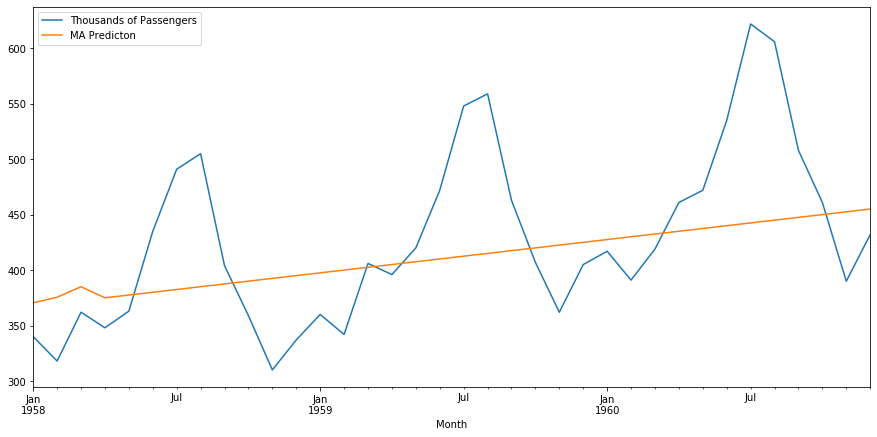

In [1249]:
#create plots between test and prediction
test_data.plot(legend=True, label = 'Test Data') # testdata plot
test_data_stationary['Inverted_1d_MA'].plot(legend=True, label = 'MA Predicton')
plt.show()

In [1181]:
# r2_score
arma_r2_score = r2_score(test_data['Thousands of Passengers'], test_data_stationary['Inverted_1d_MA'])
arma_r2_score

0.18479185296233125

### Autoregression Moving Averages(ARMA) model
It is the combinatin of AR and MA. AR is the linear combination of lagged values of order 'p' and MA uses the past forecast errors of order 'q' in a regression-like mode .

We can directly fit original series with ARIMA model or can be obtained the same result by making data stationary at first and pass it with the model ARMA. We have already changed into stationary data. So. lets use that data  with ARMA. 


In [1252]:
#tune parameter  for ARMA
auto_arima(train_data_stationary, seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  107
Model:                     ARMA(2, 4)   Log Likelihood                -467.805
Method:                       css-mle   S.D. of innovations             18.250
Date:                Mon, 18 Nov 2019   AIC                            951.609
Time:                        21:11:05   BIC                            972.992
Sample:                             0   HQIC                           960.277
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5392      0.157     16.165      0.000       2.231       2.847
ar.L1.y        0.9160      0.078     11.670      0.000       0.762       1.070
ar.L2.y       -0.7821      0.073    -10.642      0.000      -0.926      -0.638
ma.L1.y       -0.8360      0.109     -7.645      0.000      -1.050      -0.622
ma.L2.y        0.3351      0.151      2.226      0.028       0.040       0.630
ma.L3.y        0.2955      0.125      2.364      0.020       0.051       0.540
ma.L4.y       -0.7943      0.110     -7.240      0.000      -1.009      -0.579
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5856           -0.9673j            1.1308           -0.1634
AR.2            0.5856           +0.9673j            1.1308            0.1634
MA.1            1.0001           -0.0000j            1.0001           -0.0000
MA.2            0.3153           -0.9490j            1.0000           -0.1989
MA.3            0.3153           +0.9490j            1.0000            0.1989
MA.4           -1.2587           -0.0000j            1.2587           -0.5000
-----------------------------------------------------------------------------
"""

It suggests ARMA(2, 4) model

In [1253]:
#fit model 
arma_model = ARMA(train_data_stationary['Thousands of Passengers'], order=(2,4)).fit()

#predict test data
arma_prediction = arma_model.predict(start= test_data_stationary.index[0], 
                                     end= test_data_stationary.index[-1],
                                     dynamic=False)

# put into dataframe
test_data_stationary['Prediction_1D_ARMA'] = arma_prediction


#invert data to original scale ( since predicted result is 1 differencing)
test_data_stationary['Inverted_1d_ARMA'] = df['Thousands of Passengers'].iloc[-len(test_data_stationary)-1] + test_data_stationary['Prediction_1D_ARMA'].cumsum()
test_data_stationary.head()


,Thousands of Passengers,Passengers(original),Prediction_1d_AR,Inverted_1d_AR,Prediction_1D_MA,Inverted_1d_MA,Prediction_1D_ARMA,Inverted_1d_ARMA
Month,,,,,,,,
1958-01-01,4.0,340,23.500473,359.500473,34.548432,370.548432,49.208305,385.208305
1958-02-01,-22.0,318,2.308398,361.808871,4.991931,375.540362,28.741069,413.949374
1958-03-01,44.0,362,-3.271831,358.537040,9.462509,385.002871,10.349717,424.299091
1958-04-01,-14.0,348,0.140311,358.677351,-9.970430,375.032441,-34.201682,390.097409
1958-05-01,15.0,363,2.762978,361.440329,2.501115,377.533556,-37.225431,352.871978


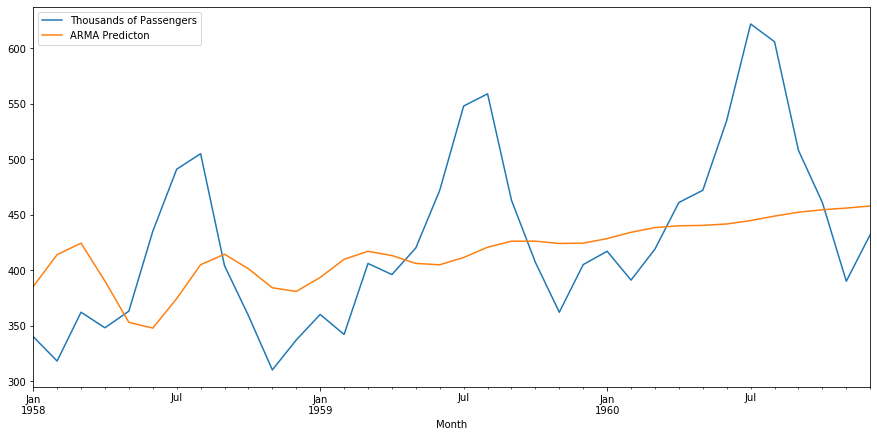

In [1254]:
#create plots between test and prediction
test_data.plot(legend=True, label = 'Test Data') # testdata plot

test_data_stationary['Inverted_1d_ARMA'].plot(legend=True, label = 'ARMA Predicton')
plt.show()

Looks this model also doesn't learn much for this dataset. It predict in linear behaviour.

In [1255]:
test_data_stationary['Inverted_1d_ARMA'].mean()

416.30909725267526

In [1256]:
test_data.mean()

Thousands of Passengers    428.5
dtype: float64

### Evaluate model

In [1257]:
# r2_score
arma_r2_score = r2_score(test_data['Thousands of Passengers'], test_data_stationary['Inverted_1d_ARMA'])
arma_r2_score

0.1418787904840343

In [1301]:
# absolute mean error
mean_absolute_error(test_data['Thousands of Passengers'], test_data_stationary['Inverted_1d_ARMA'])

57.26592096364511

It  has r2_score = 0.14. Still, model doesn't predict well. And, it is true also since we have 
dataset having seasonality which cann't handle by ARMA.

### Future Forcast

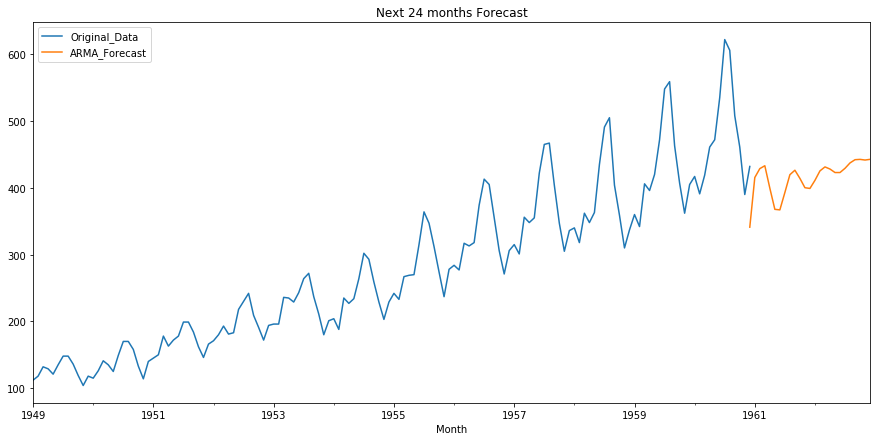

In [1302]:
# train with whole dataset(stationary)
arma_model = ARMA(stat_data['Thousands of Passengers'], order=(2,4)).fit()


#forecast next 24
arma_forecast = arma_model.predict(start=stat_data.index[-1], 
                                      end=stat_data.index[-1]+24, 
                                      dynamic=False)

#orignal data
original_arma_forecast= df['Thousands of Passengers'].iloc[-len(test_data_stationary)-1] + arma_forecast.cumsum()

#create plots
ax=  df['Thousands of Passengers'].plot(legend= True, label='Original_Data', title='Next 24 months Forecast')
original_arma_forecast.plot(legend= True, label='ARMA_Forecast')
ax.legend(loc=2);


### Autoregression Integration Moving Average(ARIMA)
This model combines AR, I and MA.  AR = Autoregression, I = Integration and MA = Moving Average. This model directly converts the non-stationary series to stationary.
This is equavalent to ARMA(p,q) after differencing the original series with d in  ARIMA(p,d,q). This model address trend but not seasonality.



In [1143]:
#tune  parameter for ARIMA
auto_arima(df['Thousands of Passengers'], seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  143
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -661.292
Method:                       css-mle   S.D. of innovations             23.715
Date:                Sun, 17 Nov 2019   AIC                           1338.585
Time:                        14:10:48   BIC                           1362.288
Sample:                             1   HQIC                          1348.216
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6854      0.134     19.979      0.000       2.422       2.949
ar.L1.D.y      0.9142      0.082     11.131      0.000       0.753       1.075
ar.L2.D.y     -0.7709      0.080     -9.629      0.000      -0.928      -0.614
ma.L1.D.y     -0.8356      0.101     -8.265      0.000      -1.034      -0.637
ma.L2.D.y      0.3271      0.122      2.691      0.008       0.089       0.565
ma.L3.D.y      0.3086      0.114      2.699      0.008       0.085       0.533
ma.L4.D.y     -0.8000      0.079    -10.112      0.000      -0.955      -0.645
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5929           -0.9724j            1.1389           -0.1628
AR.2            0.5929           +0.9724j            1.1389            0.1628
MA.1            1.0001           -0.0000j            1.0001           -0.0000
MA.2            0.3178           -0.9481j            1.0000           -0.1985
MA.3            0.3178           +0.9481j            1.0000            0.1985
MA.4           -1.2500           -0.0000j            1.2500           -0.5000
-----------------------------------------------------------------------------
"""

##### Note: 
ARIMA(p,d,q) is same as ARMA(p,q) after differncing  data with order 'd'. We can see this later.

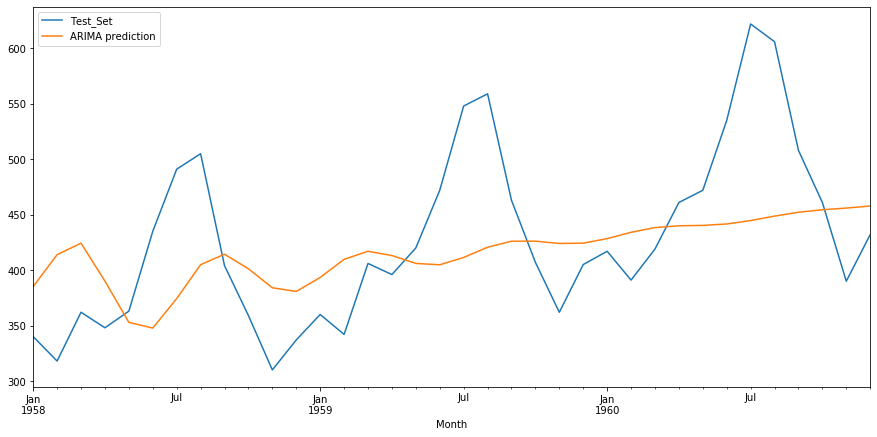

In [1297]:
#build model
arima_mode = ARIMA(train_data['Thousands of Passengers'], order=(2,1,4)).fit()

#forecast next 24
arima_prediction = arima_mode.predict(start=test_data.index[0], 
                                     end=test_data.index[-1],
                                     typ='levels',
                                     dynamic=False)

#create plots with test_data and prediction
test_data['Thousands of Passengers'].plot(legend=True, label='Test_Set')
arima_prediction.plot(legend=True, label='ARIMA prediction')
plt.show()


### Evaluate

In [1299]:
# r2_score
arma_r2_score = r2_score(test_data['Thousands of Passengers'], arima_prediction)
arma_r2_score

0.14187879048403407

In [1300]:
#mean_absolute
absmean = mean_absolute_error(test_data['Thousands of Passengers'], arima_prediction)
absmean

57.26592096364512

##### Observation:
We got the exact same result from the two models ARMA(2,4) with data after differencing '1' and ARIMA(2,1,4) with out differencing data(original).

### ARIMA Forecast

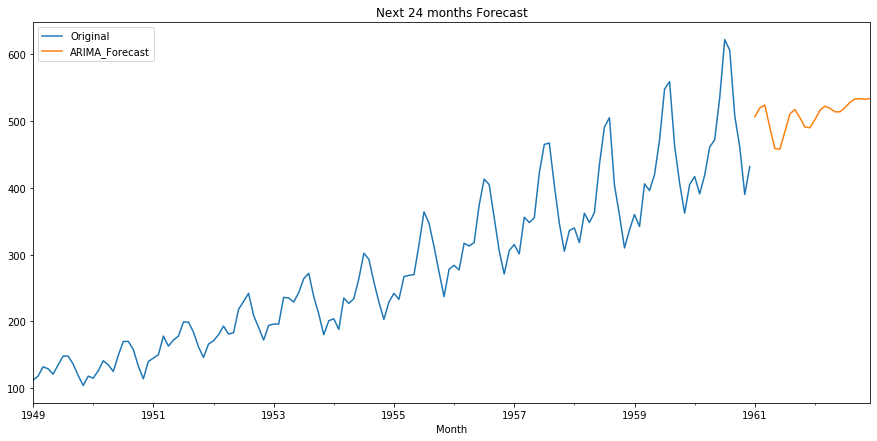

In [1303]:
# train with whole dataset
arima_model_f = ARIMA(df['Thousands of Passengers'], order=(2, 1, 4)).fit()


#forecast next 24 months
arima_prediction_f = arima_model_f.predict(start=len(df), 
                                      end=len(df)+23,
                                      typ='levels',
                                      dynamic=False)

#create plots
ax=  df['Thousands of Passengers'].plot(title= 'Next 24 months Forecast',legend= True, label='Original')
arima_prediction_f.plot(legend= True, label='ARIMA_Forecast')
ax.legend(loc=2)
plt.show()

### Seasonal Autoregressive Integrated Moving Averages (SARIMA(p,d,q)(P,D,Q)m)
This model addresses the seasonality of series. It has additional paramerter (P,D,Q)m, where P,D,Q represent the seasonal regression, differencing and moving average coefficients respectively and  'm' represents the number of data points (rows) in each seasonal cycle.

In [1305]:
#tune  parameter for SARIMAX
auto_arima(df['Thousands of Passengers'], seasonal=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -666.022
Date:                Mon, 18 Nov 2019   AIC                           1344.044
Time:                        21:55:37   BIC                           1361.821
Sample:                             0   HQIC                          1351.268
                                - 144                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6619      0.193      3.425      0.001       0.283       1.041
ar.L1          1.6479      0.028     58.889      0.000       1.593       1.703
ar.L2         -0.9096      0.025    -36.755      0.000      -0.958      -0.861
ma.L1         -1.9079      0.355     -5.371      0.000      -2.604      -1.212
ma.L2          0.9977      0.371      2.689      0.007       0.270       1.725
sigma2       611.7553    246.970      2.477      0.013     127.704    1095.807
===================================================================================
Ljung-Box (Q):                      358.18   Jarque-Bera (JB):                 2.78
Prob(Q):                              0.00   Prob(JB):                         0.25
Heteroskedasticity (H):               7.02   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Build SARIMAX Model

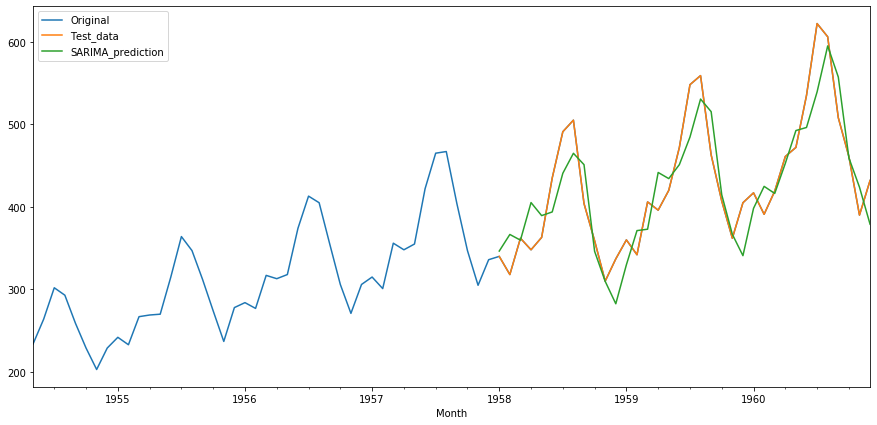

In [1306]:
# use the sugessted parameters
sarima_mode = SARIMAX(df['Thousands of Passengers'], order=(2, 1, 2)).fit()

#forecast next 24
sarima_prediction = sarima_mode.predict(start=len(train_data), 
                                      end=len(train_data)+len(test_data)-1,
                                      typ='levels',
                                      dynamic=False)

#create plots
ax= df['Thousands of Passengers'].iloc[-80:].plot(legend= True, label='Original')
test_data['Thousands of Passengers'].plot(legend= True, label='Test_data')
sarima_prediction.plot(legend= True, label='SARIMA_prediction')
ax.legend(loc=2);

#### Model Evaluate

In [1307]:
#r2_score
sarima_r2_score= r2_score(test_data['Thousands of Passengers'], sarima_prediction)
sarima_r2_score


0.7650099434475135

In [1308]:
#mean_absolute
absmean = mean_absolute_error(test_data['Thousands of Passengers'], sarima_prediction)
absmean

31.545468954422674

In [1309]:
# test data std
test_data.std()

Thousands of Passengers    79.329152
dtype: float64

#### Note: 
We can see that SARIMA model gives better result than ARIMA since SARIMA model address seasonlity, but lack in ARIMA model.

### Forcast with SARIMA model

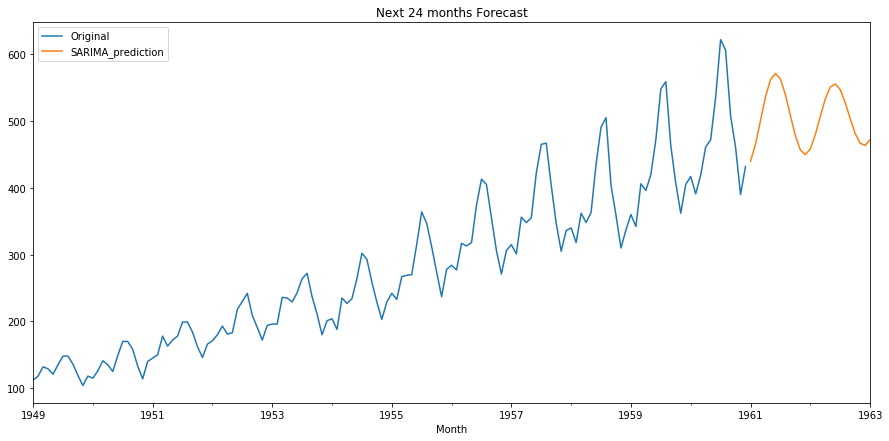

In [1310]:
# train with whole dataset
sarima_model = SARIMAX(df['Thousands of Passengers'], order=(2, 1, 2)).fit()


#forecast next 24 months
sarima_prediction = sarima_model.predict(start=len(df), 
                                      end=len(df)+24, 
                                      dynamic=False)

#create plots
ax=  df['Thousands of Passengers'].plot(title= 'Next 24 months Forecast',legend= True, label='Original')
sarima_prediction.plot(legend= True, label='SARIMA_prediction')
ax.legend(loc=2)
plt.show()

#### Conclusion:
When we comapare these models(AR, MA, ARMA/ARIMA, SARIMA), the result get better from SARIMA model. I have also tried this dataset with Holt-Winter method which did very good result with additive trend(mean_absolute_error = 25.8, bit lesser than SARIMA result). You can find the Holt-Winter method result in the another jupyter notebook 'Time-Series-Analysis (Statsmodels).ipynb'